In [123]:
import numpy as np 
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import requests
from io import BytesIO
import os
import random
import pickle
import tqdm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [7]:
root_path = './'

In [8]:
### READ DATA ###

df = pd.read_json(root_path + 'Crack.json', lines=True)
df['label'] = df.annotation.apply(lambda x: x['labels'][0] if len(x['labels'])==1 else 'Crack')
print(df.shape)
df.head()

(1428, 5)


,content,annotation,extras,metadata,label
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371420000, 'last_updated...",no Crack
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528373761000, 'last_updated...",Crack
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371146000, 'last_updated...",Crack
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['Crack'], 'note': ''}",NaN,"{'first_done_at': 1528371734000, 'last_updated...",Crack
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"{'labels': ['no Crack'], 'note': ''}",NaN,"{'first_done_at': 1528372265000, 'last_updated...",no Crack


In [70]:
### GET AND PREPARE IMAGES ###

images = []

for url in tqdm.tqdm(df['content']):
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    numpy_img = np.array(img)
    img_batch = np.expand_dims(numpy_img, axis=0)
    images.append(img_batch.astype('float16'))
    
images = np.vstack(images)
print(images.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1428/1428 [12:53<00:00,  1.85it/s]


(1428, 224, 224, 3)


In [102]:
if not os.path.isfile('dataset_images.npy'):
    np.save('dataset_images.npy',images)

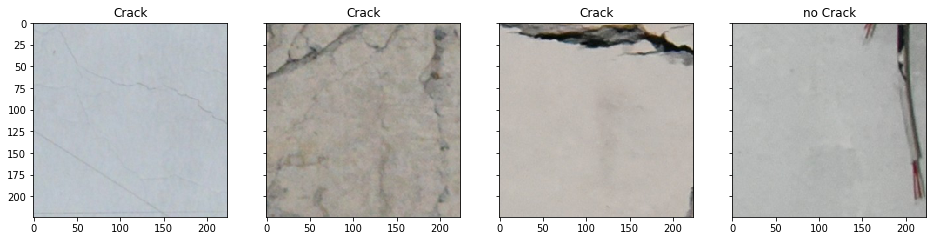

In [71]:
### RANDOM IMAGES PLOT ###

random_id = np.random.randint(0,images.shape[0],4)
f, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize = (16,10))

for ax, img, title in zip(axes.ravel(), images[random_id], df['label'][random_id]):
    ax.imshow(Image.fromarray((np.uint8(img))))
    ax.set_title(title)

In [240]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df.label.values)
classes = le.classes_

In [241]:
### CREATE TRAIN TEST ###

X_train, X_test, y_train, y_test = train_test_split(images, y, random_state = 42, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state = 42, test_size=0.1)

In [242]:
import torch
import torchvision
from torch.utils.data import Dataset
class WallCrackDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.X = np.uint8(X)
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sampleX = Image.fromarray(self.X[idx])
        
        if self.transform:
             sampleX = self.transform(sampleX)

        sample = (sampleX, self.y[idx])



        return sample

In [243]:

from torchvision import transforms

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
#                                        torchvision.transforms.RandomAffine(30,translate=[0,0.3],scale=(0.7,1.3),resample=Image.NEAREST),  
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                     ])

valid_transforms = transforms.Compose([transforms.ToTensor()
                                      ,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                     ])

test_transforms = transforms.Compose([transforms.ToTensor()
                                      ,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                     ])

In [244]:
# train_dataset = WallCrackDataset(X_train,y_train, transform=train_transforms)
# valid_dataset = WallCrackDataset(X_test,y_test, transform=test_transforms)
# test_dataset = WallCrackDataset(X_test,y_test, transform=test_transforms)

In [245]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [304]:
data_transfer = {}

data_transfer['train'] = WallCrackDataset(X_train,y_train, transform=train_transforms)
data_transfer['valid'] = WallCrackDataset(X_valid,y_valid, transform=valid_transforms)
data_transfer['test'] = WallCrackDataset(X_test,y_test, transform=test_transforms)

loaders_transfer = {}

loaders_transfer['train'] = torch.utils.data.DataLoader(data_transfer['train'], batch_size=32, shuffle=True)
loaders_transfer['valid'] = torch.utils.data.DataLoader(data_transfer['valid'], batch_size=32)
loaders_transfer['test'] = torch.utils.data.DataLoader(data_transfer['test'], batch_size=32)

In [305]:
# helper function to un-normalize and display an image
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])


def imshow(img):
    img = invTrans(img)  # unnormalize
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

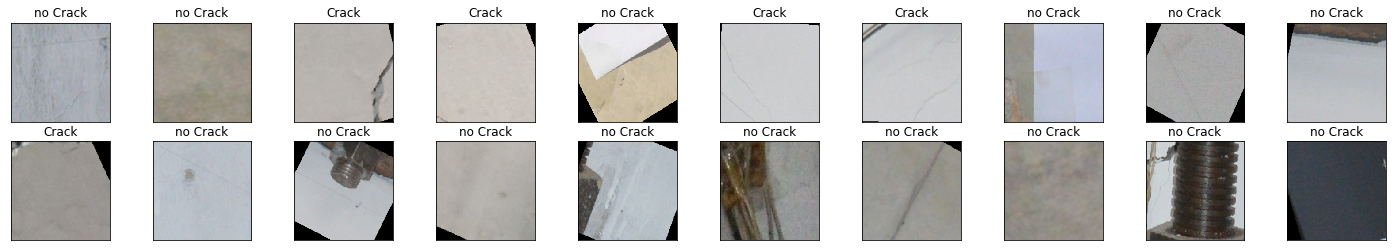

In [306]:
dataiter = iter(loaders_transfer['train'])
sample_images, labels = dataiter.next()



# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(sample_images[idx])
    ax.set_title(classes[labels[idx]])

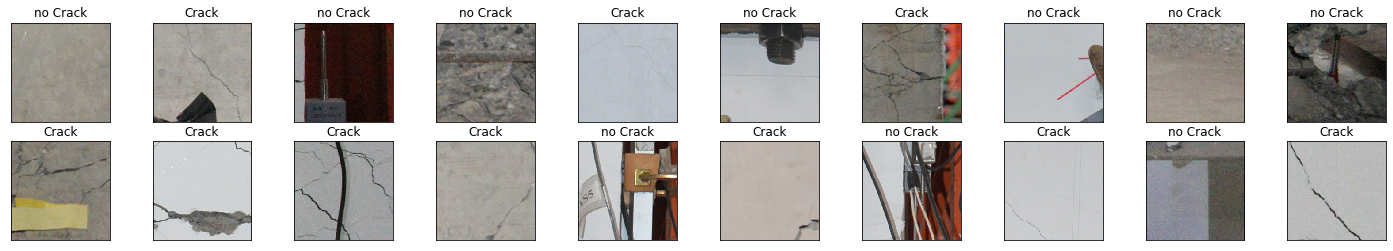

In [307]:
dataiter = iter(loaders_transfer['valid'])
sample_images, labels = dataiter.next()


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(sample_images[idx])
    ax.set_title(classes[labels[idx]])

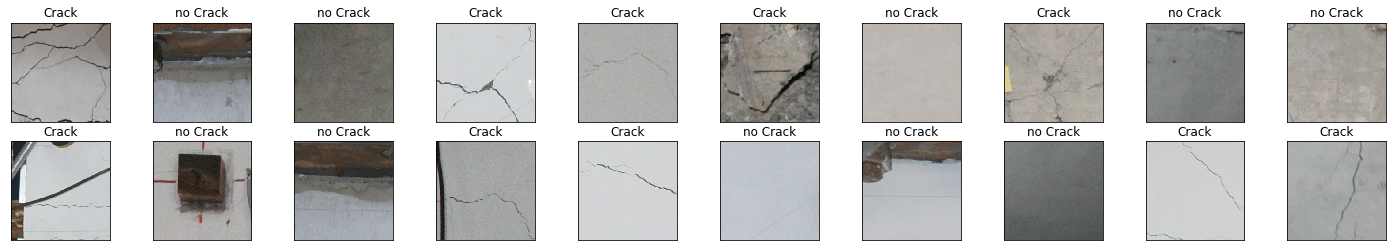

In [308]:
dataiter = iter(loaders_transfer['test'])
sample_images, labels = dataiter.next()


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(sample_images[idx])
    ax.set_title(classes[labels[idx]])

In [309]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model.forward(data)
            loss = criterion(output,target.long())
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                
                output = model.forward(data)
                loss = criterion(output,target.long())
                
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            
            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model


In [310]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target.long())
            # update average test loss 
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [311]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.vgg19(pretrained=True)

In [312]:
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [313]:
for i in model_transfer.features.named_parameters():
    layer_no = ''.join(c for c in i[0] if c.isdigit())
    if int(layer_no) <= 22:
        i[1].requires_grad = False

In [314]:
for i in model_transfer.features.named_parameters():
    print(i[0],i[1].requires_grad)

0.weight False
0.bias False
2.weight False
2.bias False
5.weight False
5.bias False
7.weight False
7.bias False
10.weight False
10.bias False
12.weight False
12.bias False
14.weight False
14.bias False
16.weight False
16.bias False
19.weight False
19.bias False
21.weight False
21.bias False
23.weight True
23.bias True
25.weight True
25.bias True
28.weight True
28.bias True
30.weight True
30.bias True
32.weight True
32.bias True
34.weight True
34.bias True


In [315]:
import torch.nn as nn

avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
                          ('0', nn.Linear(512, 2)),
                          ('1', nn.LogSoftmax(dim=1))
                          ]))
model_transfer.avgpool = avgpool
model_transfer.classifier = classifier
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [316]:
# criterion_transfer = nn.BCELoss()
criterion_transfer = nn.NLLLoss()
import torch.optim as optim

optimizer_transfer = optim.SGD(filter(lambda p: p.requires_grad, model_transfer.parameters()), lr=0.001)

In [317]:
# train the model
n_epochs = 60
model_transfer =  train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_vgg19_crack_anomaly_sgd_lr0001.pt')

Epoch: 1 	Training Loss: 0.689192 	Validation Loss: 0.684293
Validation loss decreased (inf --> 0.684293).  Saving model ...
Epoch: 2 	Training Loss: 0.680843 	Validation Loss: 0.673508
Validation loss decreased (0.684293 --> 0.673508).  Saving model ...
Epoch: 3 	Training Loss: 0.673481 	Validation Loss: 0.658204
Validation loss decreased (0.673508 --> 0.658204).  Saving model ...
Epoch: 4 	Training Loss: 0.661564 	Validation Loss: 0.647585
Validation loss decreased (0.658204 --> 0.647585).  Saving model ...
Epoch: 5 	Training Loss: 0.649012 	Validation Loss: 0.634693
Validation loss decreased (0.647585 --> 0.634693).  Saving model ...
Epoch: 6 	Training Loss: 0.639949 	Validation Loss: 0.617151
Validation loss decreased (0.634693 --> 0.617151).  Saving model ...
Epoch: 7 	Training Loss: 0.619807 	Validation Loss: 0.601880
Validation loss decreased (0.617151 --> 0.601880).  Saving model ...
Epoch: 8 	Training Loss: 0.607270 	Validation Loss: 0.584048
Validation loss decreased (0.60188

In [318]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_vgg19_crack_anomaly_sgd_lr0001.pt'))

<All keys matched successfully>

In [319]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.188809


Test Accuracy: 92% (132/143)
